# Projet 6 : Classifiez automatiquement des biens de consommation

Après avoir réalisé une classification supervisée à partir des images, nous allons appliquer une classification supervisée de la même manière que précédemment mais cette fois-ci avec des modèles plus récents. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plot_keras_history import show_history, plot_history

import P6_fonctions as fc
import importlib
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import metrics
import pickle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2M, efficientnet_v2
from tensorflow.keras.applications import ConvNeXtBase, convnext
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
np.random.seed(42)

In [3]:
importlib.reload(fc)

<module 'P6_fonctions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 6/à zip/P6_fonctions.py'>

In [4]:
# FONCTIONS 

def create_model_fct(model0, loss = "categorical_crossentropy", opti='rmsprop', option = True) :
    '''Création du modèle adapté à notre objectif de classification 
    en modifiant le modèle pré-entraîné passé en paramètre.'''
    
    # On garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    
    # Compléter le modèle pour qu'il fournisse les probabilités d'appartenir aux 7 catégories.
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss=loss, optimizer=opti, metrics=["accuracy"])

    if option == True :
        print(model.summary())
    
    return model
    
def image_prep_fct(list_photos, model=None) :
    '''Préparation des images pour la modélisation.'''
    
    prepared_images = []
    
    for image_num in range(len(list_photos)) :
        img = (load_img(
            path_images + list_photos[image_num], 
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        if model == 'EfficientNet':
            img = efficientnet_v2.preprocess_input(img)
        else :
            img = convnext.preprocess_input(img)

        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)

    return prepared_images_np

def plot_hist(hist) :
    '''Affichage de la loss et de l'accuracy en fonction des epochs.'''
    show_history(hist)
    plot_history(hist)
    plt.close()

In [5]:
df_cat = pd.read_csv('data_text_clean.csv')

In [6]:
liste_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

In [7]:
path_images = "Flipkart/Images/"
list_photos = [file for file in listdir(path_images)]

# 1. EfficientNetV2M

Nous allons commencer par appliquer le modèle EfficientNetV2M.

EfficientNetV2 est une architecture de réseau neuronal convolutif (CNN) qui est une évolution de l'architecture d'EfficientNet, conçue pour la vision par ordinateur. Son but par rapport à sa version précédente est d'améliorer les performances des modèles de vision par ordinateur tout en réduisant le coût computationnel.
EfficientNetV2 adopte une approche multi-échelle en utilisant des blocs de convolution inversée (Inverse Residual) et des connexions multi-échelles entre les différentes couches.
EfficientNetV2M est une variante de EfficientNetV2 proposant un modèle de taille moyenne par rapport aux autres variantes d'EfficientNetV2. Il a été conçu pour offrir un équilibre entre performances et coût computationnel.

In [13]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [14]:
X_train = list(X_train)
X_test = list (X_test)

In [15]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train, 'EfficientNet')
print(images_np.shape)
images_np_test = image_prep_fct(X_test,'EfficientNet')
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [16]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

In [17]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [18]:
# Création du modèle
model = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model_effi = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_effi_save_path1 = "models/model_effi_best_weights.h5"
checkpoint = ModelCheckpoint(model_effi_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_drop (Dropout)         (None, 56, 56, 48)   0           ['block2b_project_bn[0][0]']     
                                                                                                  
 block2b_add (Add)              (None, 56, 56, 48)   0           ['block2b_drop[0][0]',           
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 320)  1280       ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 320)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 80)   25600       ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 80)  320         ['block3b_project_conv[0][0]']   
 lization)

 2D)                                                             ']                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 14, 14, 320)  1280       ['block4a_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 320)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 320)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 640)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 40)     25640       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_d

 block4g_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4g_drop (Dropout)         (None, 14, 14, 160)  0           ['block4g_project_bn[0][0]']     
                                                                                                  
 block4g_add (Add)              (None, 14, 14, 160)  0           ['block4g_drop[0][0]',           
                                                                  'block4f_add[0][0]']            
                                                                                                  
 block5a_e

                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 14, 14, 1056  185856      ['block5b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_d

                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5e_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5e_expand_activation (Act  (None, 14, 14, 1056  0          ['block5e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5e_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5e_b

                                                                                                  
 block5g_expand_activation (Act  (None, 14, 14, 1056  0          ['block5g_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5g_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5g_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5g_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5g_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5g_a

                                                                                                  
 block5i_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5i_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5i_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5i_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5i_activation (Activation  (None, 14, 14, 1056  0          ['block5i_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5i_s

                                                                                                  
 block5k_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5k_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5k_activation (Activation  (None, 14, 14, 1056  0          ['block5k_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5k_se_squeeze (GlobalAver  (None, 1056)        0           ['block5k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5k_s

                                                                                                  
 block5m_activation (Activation  (None, 14, 14, 1056  0          ['block5m_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5m_se_squeeze (GlobalAver  (None, 1056)        0           ['block5m_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5m_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5m_se_squeeze[0][0]']     
                                                                                                  
 block5m_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5m_se_reshape[0][0]']     
          

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1056)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 304)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 304)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 304)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 304)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6j_dwconv2[0][0]']        
 )        

                                                                                                  
 block6l_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6l_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6l_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 1824)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block6n_activation (Activation  (None, 7, 7, 1824)  0           ['block6n_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6n_se_squeeze (GlobalAver  (None, 1824)        0           ['block6n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_s

 block6p_se_squeeze (GlobalAver  (None, 1824)        0           ['block6p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6p_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6p_se_squeeze[0][0]']     
                                                                                                  
 block6p_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6p_se_reshape[0][0]']     
                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6p_activation[0][0]',     
          

 block6r_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6r_se_reshape[0][0]']     
                                                                                                  
 block6r_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6r_se_reduce[0][0]']      
                                                                                                  
 block6r_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6r_activation[0][0]',     
                                                                  'block6r_se_expand[0][0]']      
                                                                                                  
 block6r_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6r_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 7, 7, 512)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 7, 512)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7b_add[0][0]']            
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7c_expand_conv[0][0]']    
 ization) 

                                                                  'block7c_add[0][0]']            
                                                                                                  
 block7e_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7d_add[0][0]']            
                                                                                                  
 block7e_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7e_expand_activation (Act  (None, 7, 7, 3072)  0           ['block7e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7e_d

In [19]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

history_effi = model_effi.fit(X_train, y_train, epochs=50, batch_size=128, 
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_eff = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_eff))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.0101 - accuracy: 0.3667
Epoch 1: val_loss improved from inf to 0.80699, saving model to models/model_effi_best_weights.h5
5/5 [==============================] - 79s 14s/step - loss: 1.0101 - accuracy: 0.3667 - val_loss: 0.8070 - val_accuracy: 0.7905
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7429
Epoch 2: val_loss improved from 0.80699 to 0.58006, saving model to models/model_effi_best_weights.h5
5/5 [==============================] - 36s 8s/step - loss: 0.7454 - accuracy: 0.7429 - val_loss: 0.5801 - val_accuracy: 0.8333
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.7841
Epoch 3: val_loss improved from 0.58006 to 0.44740, saving model to models/model_effi_best_weights.h5
5/5 [==============================] - 33s 7s/step - loss: 0.5624 - accuracy: 0.7841 - val_loss: 0.4474 - val_accuracy: 0.8286
Epoch 4/50
5/5 [========================

5/5 [==============================] - 32s 7s/step - loss: 0.1252 - accuracy: 0.9460 - val_loss: 0.2356 - val_accuracy: 0.8810
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9381
Epoch 27: val_loss improved from 0.23558 to 0.23309, saving model to models/model_effi_best_weights.h5
5/5 [==============================] - 29s 6s/step - loss: 0.1320 - accuracy: 0.9381 - val_loss: 0.2331 - val_accuracy: 0.8857
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9524
Epoch 28: val_loss improved from 0.23309 to 0.23231, saving model to models/model_effi_best_weights.h5
5/5 [==============================] - 31s 7s/step - loss: 0.1111 - accuracy: 0.9524 - val_loss: 0.2323 - val_accuracy: 0.8810
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9556
Epoch 29: val_loss did not improve from 0.23231
5/5 [==============================] - 29s 6s/step - loss: 0.1016 - accuracy: 0.9556 -

In [20]:
pickle.dump(model_effi, open('models/model_effi.pkl', 'wb'))

In [21]:
# Scores du dernier epoch

loss, accuracy = model_effi.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_effi.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 42s 2s/step - loss: 0.0421 - accuracy: 0.9825
Training Accuracy: 0.9825

7/7 [==============================] - 14s 2s/step - loss: 0.2380 - accuracy: 0.8857
Validation Accuracy:  0.8857


In [22]:
# Scores de l'epoch optimal

model_effi.load_weights(model_effi_save_path1)

loss_train_effi, accuracy_train_effi = model_effi.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_effi))

temps1=time.time()

loss_val_effi, accuracy_val_effi = model_effi.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_effi))

temps2_val_effi = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_effi))

temps1=time.time()

loss_test_effi, accuracy_test_effi = model_effi.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_effi))

temps2_test_effi = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_effi))

Training Accuracy: 0.9810
Validation Accuracy :  0.8810
Temps validation : 10.14 secondes
Test Accuracy       :  0.8810
Temps test : 7.79 secondes


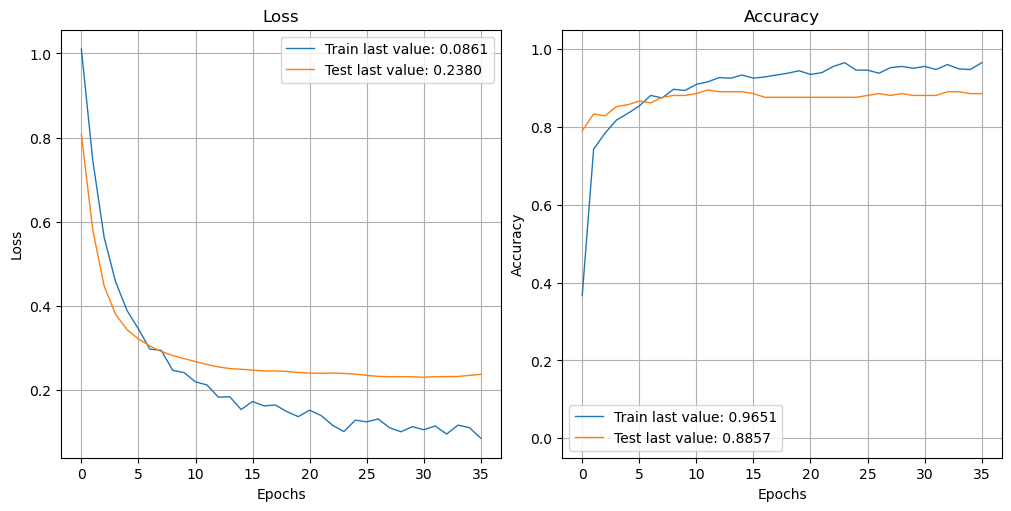

In [23]:
plot_hist(history_effi)

In [24]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_effi.predict(X_val), axis=1)

7/7 [==============================] - 37s 3s/step


In [25]:
conf_mat_effi = metrics.confusion_matrix(y_val_num, y_val_pred)

In [26]:
corresp = 'argmax'
y_val_pred_transform_effi = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat_effi = metrics.confusion_matrix(y_val_num, y_val_pred_transform_effi)

print(metrics.classification_report(y_val_num, y_val_pred_transform_effi))

Correspondance des clusters :  [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.96      0.80      0.87        30
           2       0.97      0.90      0.93        31
           3       0.81      0.84      0.83        31
           4       0.79      0.93      0.86        29
           5       0.83      0.91      0.87        32
           6       1.00      1.00      1.00        29

    accuracy                           0.88       210
   macro avg       0.89      0.88      0.88       210
weighted avg       0.89      0.88      0.88       210



<Axes: >

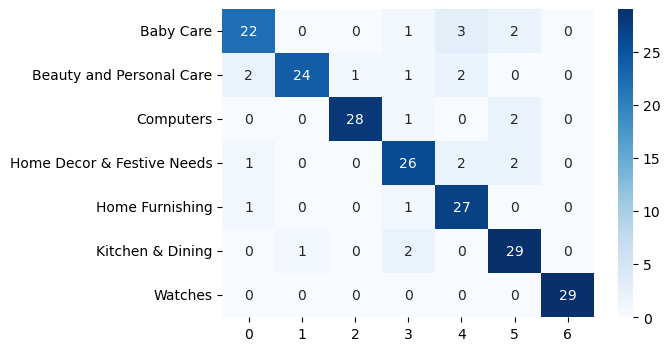

In [27]:
df_cm_effi = pd.DataFrame(conf_mat_effi, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_effi, annot=True, cmap="Blues")

On observe que le modèle ne fait que peu d'erreurs.



# 2. ConvNeXtBase

On applique désormais de la même manière le modèle ConvNeXtBase.

ConvNext est un type d'architecture de réseau neuronal convolutif (CNN) qui se distingue par l'utilisation de convolutions factorisées en "chemins" parallèles pour traiter les données d'entrée, qui permettent de capturer des informations spatiales à différentes échelles. Cette approche de factorisation des convolutions permet à ConvNeXt de réduire le nombre total de paramètres et la complexité computationnelle, tout en préservant la capacité du modèle à apprendre des motifs complexes. 
ConvNextBase est une variante de ConvNext proposant un modèle de taille moyenne par rapport aux autres variantes.

In [28]:
# Séparation du jeu de données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_cat['image'], df_cat['label'], test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(840,)
(840,)
(210,)
(210,)


In [29]:
X_train = list(X_train)
X_test = list (X_test)

In [30]:
# Traitement des images pour les rendre exploitables par l'algorithme 
images_np = image_prep_fct(X_train)
print(images_np.shape)
images_np_test = image_prep_fct(X_test)
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [31]:
X = images_np
y = to_categorical(y_train)

X_test = images_np_test
y_test = to_categorical(y_test)

In [32]:
# Séparation du jeu de train en jeu de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
X_train.shape

(630, 224, 224, 3)

In [33]:
# Création du modèle
model = ConvNeXtBase(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model_conv = create_model_fct(model, loss='categorical_hinge', opti='adam')

# Création du callback
model_conv_save_path1 = "models/model_conv_best_weights.h5"
checkpoint = ModelCheckpoint(model_conv_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

350926856/350926856 [==============================] - 12s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 56, 56, 128)  6528       ['convnext_base_prestem_normaliza
 )                      

 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 56, 56, 128)  0          ['tf.__operators__.add_1[0][0]', 
 mbda)                                                            'convnext_base_stage_0_block_2_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_downsampling_blo  (None, 28, 28, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 28, 28, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise

                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_downsampling_blo  (None, 14, 14, 512)  525312     ['tf.__operators__.add_5[0][0]'] 
 ck_1 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 14, 14, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 14, 14, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
          

                                                                                                  
 convnext_base_stage_2_block_3_  (None, 14, 14, 512)  1024       ['convnext_base_stage_2_block_3_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 14, 14, 2048  1050624    ['convnext_base_stage_2_block_3_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 14, 14, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_

 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 14, 14, 512)  1049088    ['convnext_base_stage_2_block_6_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 14, 14, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 14, 14, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
          

 convnext_base_stage_2_block_9_  (None, 14, 14, 512)  0          ['convnext_base_stage_2_block_9_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 14, 14, 512)  0          ['tf.__operators__.add_14[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_9_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 14, 14, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_

                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_13  (None, 14, 14, 512)  25600      ['tf.__operators__.add_18[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_13  (None, 14, 14, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 14, 14, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwis

 convnext_base_stage_2_block_16  (None, 14, 14, 512)  1024       ['convnext_base_stage_2_block_16_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 14, 14, 2048  1050624    ['convnext_base_stage_2_block_16_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 14, 14, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_

 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_19  (None, 14, 14, 2048  0          ['convnext_base_stage_2_block_19_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 14, 14, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 14, 14, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
          

 convnext_base_stage_2_block_22  (None, 14, 14, 512)  1049088    ['convnext_base_stage_2_block_22_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_22  (None, 14, 14, 512)  512        ['convnext_base_stage_2_block_22_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_22  (None, 14, 14, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 14, 14, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)   

                                                                                                  
 convnext_base_stage_2_block_25  (None, 14, 14, 512)  0          ['convnext_base_stage_2_block_25_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 14, 14, 512)  0          ['tf.__operators__.add_30[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 14, 14, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
          

                                                                                                  
 tf.__operators__.add_34 (TFOpL  (None, 7, 7, 1024)  0           ['tf.__operators__.add_33[0][0]',
 ambda)                                                           'convnext_base_stage_3_block_1_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 7, 7, 1024)  51200       ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)                                                                          
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 7, 7, 1024)  2048        ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
          

In [36]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1=time.time()

with tf.device('/cpu:0'):
    history_conv = model_conv.fit(X_train, y_train, epochs=50, batch_size=128, 
                                  callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

temps2_train_conv = np.round(time.time()-temps1, 2)
print("Temps d'entrainement : {} secondes".format(temps2_train_conv))

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.3444  
Epoch 1: val_loss improved from inf to 0.65512, saving model to models/model_conv_best_weights.h5
5/5 [==============================] - 689s 147s/step - loss: 1.0363 - accuracy: 0.3444 - val_loss: 0.6551 - val_accuracy: 0.7524
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.7333  
Epoch 2: val_loss improved from 0.65512 to 0.41751, saving model to models/model_conv_best_weights.h5
5/5 [==============================] - 697s 150s/step - loss: 0.5886 - accuracy: 0.7333 - val_loss: 0.4175 - val_accuracy: 0.8524
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8476  
Epoch 3: val_loss improved from 0.41751 to 0.30422, saving model to models/model_conv_best_weights.h5
5/5 [==============================] - 724s 153s/step - loss: 0.3824 - accuracy: 0.8476 - val_loss: 0.3042 - val_accuracy: 0.8571
Epoch 4/50
5/5 [==========

In [37]:
pickle.dump(model_conv, open('models/model_conv.pkl', 'wb'))

In [39]:
# Scores du dernier epoch

loss, accuracy = model_conv.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_conv.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 229s 11s/step - loss: 0.0211 - accuracy: 0.9889
Training Accuracy: 0.9889

7/7 [==============================] - 78s 11s/step - loss: 0.1814 - accuracy: 0.9048
Validation Accuracy:  0.9048


In [40]:
# Scores de l'epoch optimal

model_conv.load_weights(model_conv_save_path1)

loss_train_conv, accuracy_train_conv = model_conv.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train_conv))

temps1=time.time()

loss_val_conv, accuracy_val_conv = model_conv.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_conv))

temps2_val_conv = np.round(time.time()-temps1, 2)
print("Temps validation : {} secondes".format(temps2_val_conv))

temps1=time.time()

loss_test_conv, accuracy_test_conv = model_conv.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_conv))

temps2_test_conv = np.round(time.time()-temps1, 2)
print("Temps test : {} secondes".format(temps2_test_conv))

Training Accuracy: 0.9873
Validation Accuracy :  0.9143
Temps validation : 76.56 secondes
Test Accuracy       :  0.9048
Temps test : 76.75 secondes


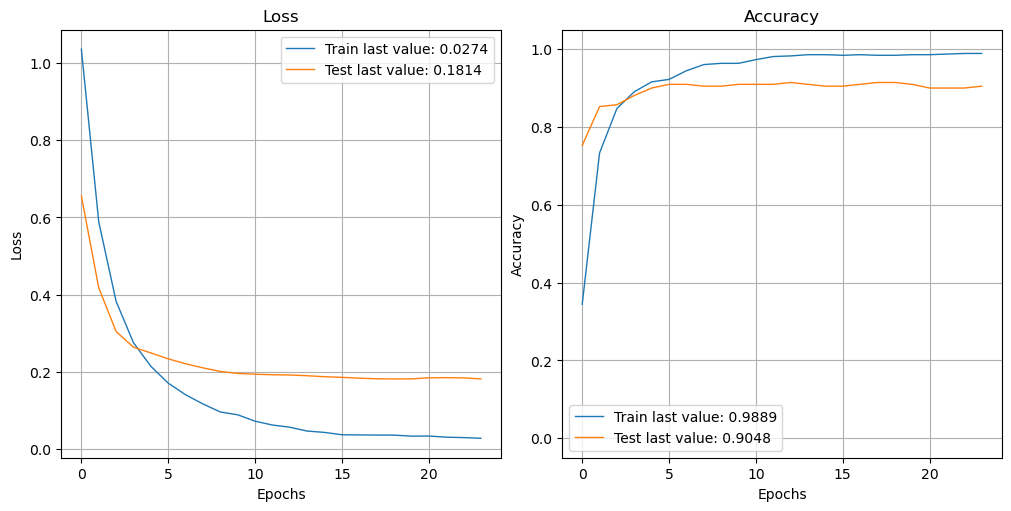

In [41]:
plot_hist(history_conv)

In [43]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_conv.predict(X_val), axis=1)

7/7 [==============================] - 77s 11s/step


In [44]:
conf_mat_conv = metrics.confusion_matrix(y_val_num, y_val_pred)

In [45]:
corresp = 'argmax'
y_val_pred_transform_conv = fc.conf_mat_transform(y_val_num, y_val_pred, corresp)
conf_mat_conv = metrics.confusion_matrix(y_val_num, y_val_pred_transform_conv)

print(metrics.classification_report(y_val_num, y_val_pred_transform_conv))

Correspondance des clusters :  [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.96      0.83      0.89        30
           2       0.94      0.94      0.94        31
           3       0.84      0.84      0.84        31
           4       0.93      0.97      0.95        29
           5       0.91      0.97      0.94        32
           6       0.97      1.00      0.98        29

    accuracy                           0.91       210
   macro avg       0.91      0.91      0.91       210
weighted avg       0.91      0.91      0.91       210



<Axes: >

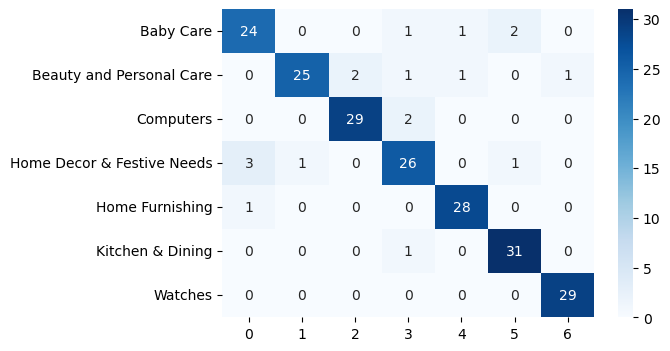

In [46]:
df_cm_conv = pd.DataFrame(conf_mat_conv, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm_conv, annot=True, cmap="Blues")